# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [ ]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [ ]:
!pip install sentencepiece

In [ ]:
import torch
import numpy as np
from dataset import TextDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [ ]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [ ]:
from model import LanguageModel

In [ ]:
model = LanguageModel(train_set)

In [ ]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    model.to(device)
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

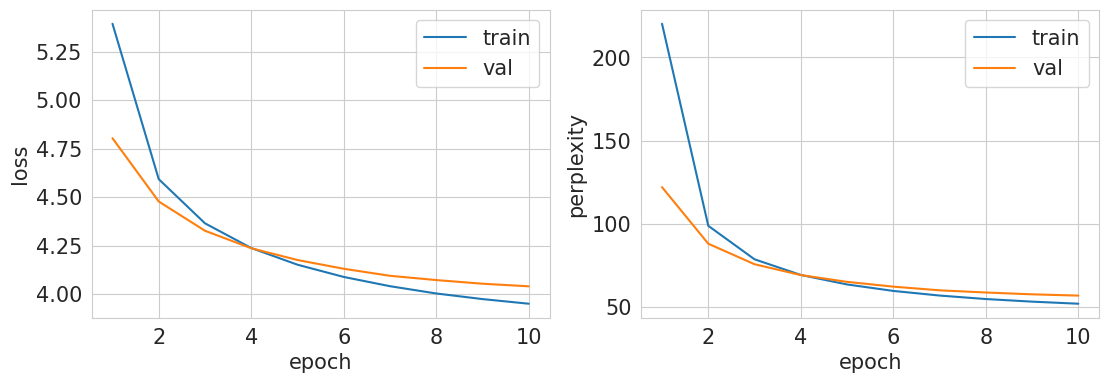

Generation examples:
мяг за крыс для экзамен. ответственность помогают они нас пропадают место - дорабатыми - свеже, ид, власть, кто так долго не хотят волосы навсегда.
потеряла жене- я так открыл дверь, а это андрей, а член поживайся!
на украине ногой одни знают резать и границах после работы и лица на ней все в людях так, ту зим выступлениях ничего не понял?
ночь на стрессерест петровщицы одного районеза находят зажиба!
- я же отдаю! что это без выхода в котором ничего не раздевал?- ты жрать, товарищ команди снег - это еще меркль...


In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from train import train
from torch.utils.data import DataLoader

model = LanguageModel(train_set).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=3e-4, max_lr=4e-3, step_size_up=50, mode='triangular2', cycle_momentum=False)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=10)
torch.save(model.state_dict(), f"rnn_model.pt")

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

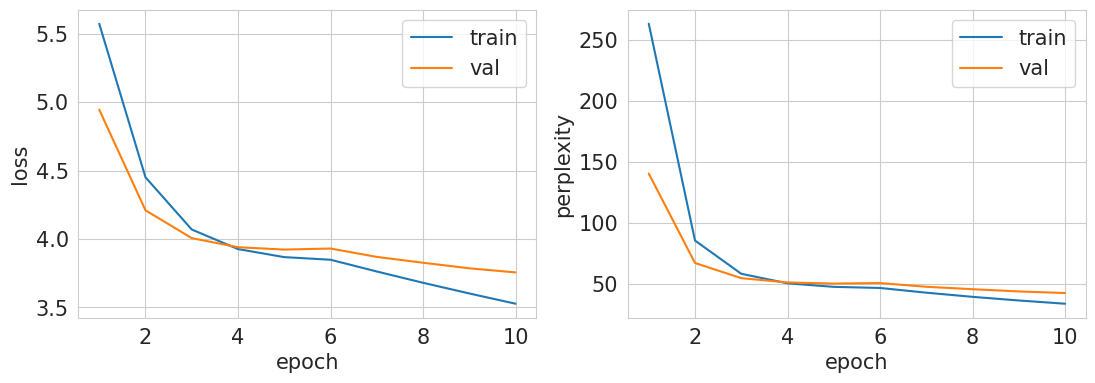

Generation examples:
рин сил вибратовая степа-пуээ.
три часами, кобелям, понял, что сходила на твою дверь, чтобы неза этих денег - это еще не изменится.
конец светлу приступили дтп.
с точки взвешивает внуками по центру- пастерство уже снимают.
вместо гродя израилась палинной и болгарханная, а во время подъезда от старой пьющих похоронное действия...


In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=3e-4, max_lr=4e-3, step_size_up=5, mode='triangular2', cycle_momentum=False)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=10)
torch.save(model.state_dict(), f"lstm.pt")

В целом видно, что метрике у LSTM лучше, но в данном случае больше смешнявок у RNN.

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
prefix = "Василь Иваныч, а что такое нюанс"
for temp in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 2.0, 5.0]:
    print(f"Temperature: {temp}")
    print(model.inference(prefix=prefix, temp=temp))
    print("-" * 50)

Temperature: 0.01
василь иваныч, а что такое нюанс?- это когда ты в ней не было.
--------------------------------------------------
Temperature: 0.1
василь иваныч, а что такое нюанс?- это когда ты не можешь найти себе другого.
--------------------------------------------------
Temperature: 0.2
василь иваныч, а что такое нюанс?- это когда ты в ней не вышел.
--------------------------------------------------
Temperature: 0.3
василь иваныч, а что такое нюанс?- это когда на него смотрит на него.
--------------------------------------------------
Temperature: 0.4
василь иваныч, а что такое нюанс?- да, а что?- а я не в том, что это не работает.
--------------------------------------------------
Temperature: 0.5
василь иваныч, а что такое нюанс?- белое.
--------------------------------------------------
Temperature: 0.75
василь иваныч, а что такое нюанс, тем больше не поддерались.
--------------------------------------------------
Temperature: 1.0
василь иваныч, а что такое нюанс.
-----------

In [ ]:
prefix = "Поймали русского, немца и еврея. Спустился к ним король и говорит"
for temp in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 2.0, 5.0]:
    print(f"Temperature: {temp}")
    print(model.inference(prefix=prefix, temp=temp))
    print("-" * 50)

Temperature: 0.01
поймали русского, немца и еврея. спустился к ним король и говорит- а что, у вас есть?
--------------------------------------------------
Temperature: 0.1
поймали русского, немца и еврея. спустился к ним король и говорит- а я, конечно, не могу, а я не могу, а потом я не могу.
--------------------------------------------------
Temperature: 0.2
поймали русского, немца и еврея. спустился к ним король и говорит- а что, у меня нет?
--------------------------------------------------
Temperature: 0.3
поймали русского, немца и еврея. спустился к ним король и говорит- дайте мне, пожалуйста, по-моему, понедельник!
--------------------------------------------------
Temperature: 0.4
поймали русского, немца и еврея. спустился к ним король и говорит- а ты что, не хочешь?
--------------------------------------------------
Temperature: 0.5
поймали русского, немца и еврея. спустился к ним король и говорит- а почему ты так думаешь?- да, сынок, наглость не должна!
-----------------------

In [ ]:
prefix = "Поручик Ржевский идет мимо казармы и слышит за углом характерное журчание"
for temp in [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 2.0, 5.0]:
    print(f"Temperature: {temp}")
    print(model.inference(prefix=prefix, temp=temp))
    print("-" * 50)

Temperature: 0.001
поручик ржевский идет мимо казармы и слышит за углом характерное журчание- а что, у вас есть?- нет, я не могу, а я не могу, а я не могу, а я не могу, а я не могу, а я не могу, а потом я не могу.
--------------------------------------------------
Temperature: 0.1
поручик ржевский идет мимо казармы и слышит за углом характерное журчание- а что, у вас есть?- нет, я не знаю, что делать.
--------------------------------------------------
Temperature: 0.2
поручик ржевский идет мимо казармы и слышит за углом характерное журчание- иван-царевич, а ты что, не знаешь, что это такое?
--------------------------------------------------
Temperature: 0.3
поручик ржевский идет мимо казармы и слышит за углом характерное журчание- а что, вы, наверное, не хотите, чтобы вы не поедем?
--------------------------------------------------
Temperature: 0.4
поручик ржевский идет мимо казармы и слышит за углом характерное журчание- ну, и как?- да, а что?- ну, это не такой уж и не убьет.
--------

С этим заданием я изрядно поигрался (не из-за температуры - с ней и так все понятно, что при ее повышении начинается бредогенерация, хотя при очень низкой температуре анекдоты застревают и получаются не очень смешными). Выбарны эти префиксы были потому, что они составляют золотой фонд анекдтов категории б (вооюще, можно еще отметить, что длина префикса не очень коррелирует с длиной оставшейся последовательности до еофа).

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
train_set = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, sp_model_prefix='bpe_5000')
valid_set = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, sp_model_prefix='bpe_5000')

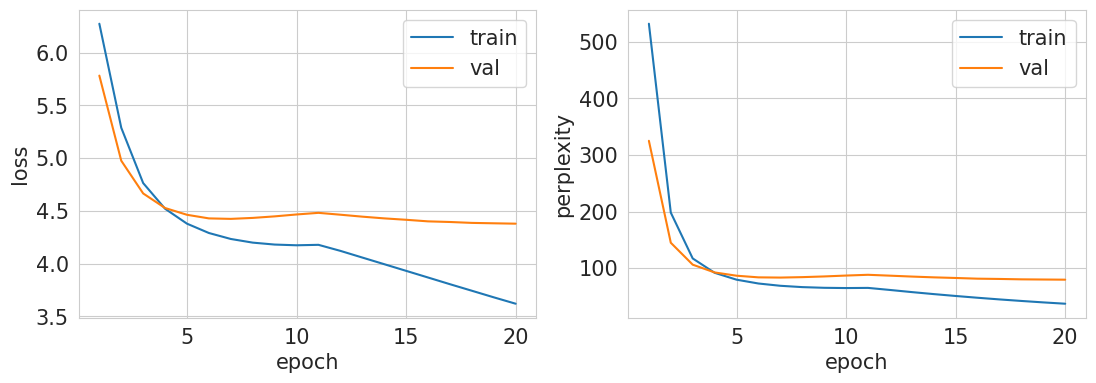

Generation examples:
идет мужик в службу.рел, говорит- доктор, а кто?- юрист, мы подумайте, кайфу не можешь!
- после этого отражения скоро будет работодателя!
древние древние души.
говорят мужчина о бейнеобразно пошла.
- плюс ничего не отрядился!


In [ ]:
from train import train
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(train_set, 64, shuffle=True)
val_loader = DataLoader(valid_set, 64, shuffle=False)
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=3e-4, max_lr=4e-3, step_size_up=10, mode='triangular2', cycle_momentum=False)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=20)
torch.save(model.state_dict(), f"lstm_bpe.pt")

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram')

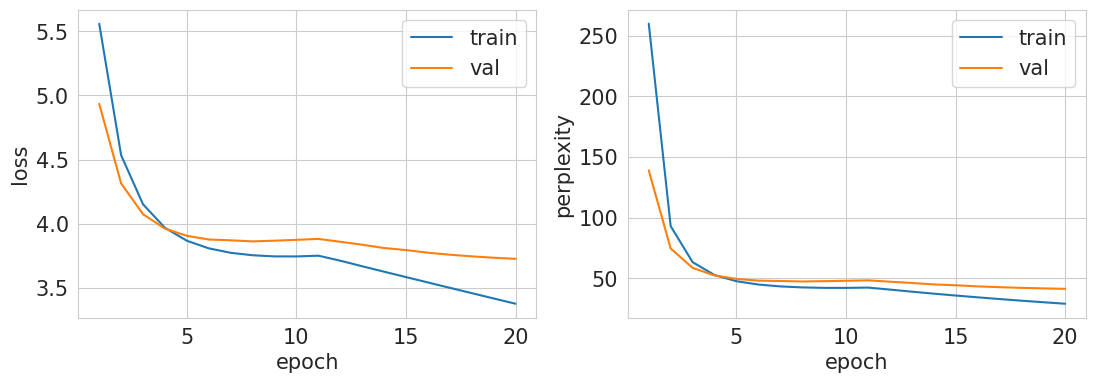

Generation examples:
- люба рубашка гроба.
эффективней выспирангически из благополовации инвали...
только один день обездоли...
- мужчине - и всегда что, сердце.
автоматов, а в ходе подольше внезапно через пару минут еще как.


In [ ]:
train_loader = DataLoader(train_set, 64, shuffle=True)
val_loader = DataLoader(valid_set, 64, shuffle=False)
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=3e-4, max_lr=4e-3, step_size_up=10, mode='triangular2', cycle_momentum=False)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=20)
torch.save(model.state_dict(), f"lstm_unigram.pt")

Про perplexity вообще вопрос интересный. Если говрить с пратической точик зрения, то есть метрика, мы на нее смотрим, остальное нас не волнует. Если же почитать интуицию за perplexity, то с одной стороны, это мера удивленности модели (обратная веротяность), а с другой среднее число вариантов при предсказании модели. Т.е. потенциально это может зависеть как от размера словаря, так и от самой структуры (закончить "... на" можно как новым словом, так и корнем от, если токеном была приставка).

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def LSA(model, valid_texts, temp=1.0):
    generated = [model.inference(temp=temp) for _ in range(len(valid_texts))]
    normalized_valid_texts = [model.dataset.ids2text(model.dataset.text2ids(text)) for text in valid_texts]
    corpus = normalized_valid_texts + generated

    tfidf = TfidfVectorizer().fit_transform(corpus)
    vectors = TruncatedSVD(n_components=50, random_state=42).fit_transform(tfidf)

    val_vectors = vectors[:len(normalized_valid_texts)]
    gen_vectors = vectors[len(normalized_valid_texts):]

    similarities = []
    for gen_vec in gen_vectors:
        sims = cosine_similarity(gen_vec.reshape(1, -1), val_vectors)
        similarities.append(sims.max())
    return val_vectors, gen_vectors, np.mean(similarities)

In [ ]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm.pt'))
val_bpe, gen_bpe, similarity = LSA(model, valid_set.texts)
print(f'Cosine similarity bpe {similarity}')

<ipython-input-22-42a4f0b5ed8c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm.pt'))


Cosine similarity bpe 0.836882025586319


In [ ]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm_bpe.pt'))
val_bpe_5000, gen_bpe_5000, similarity = LSA(model, valid_set.texts)
print(f'Cosine similarity bpe5000 {similarity}')

<ipython-input-23-9fb0bdd7a03b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_bpe.pt'))


Cosine similarity bpe5000 0.8491892745872721


In [ ]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm_unigram.pt'))
val_unigram, gen_unigram, similarity = LSA(model, valid_set.texts)
print(f'Cosine similarity unigram {similarity}')

<ipython-input-24-e4e67ad6d724>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_unigram.pt'))


Cosine similarity unigram 0.8325447340804529


Из плюсов можно отметить учет семантики, а также понижение размерности (что потенциально позволяет выделять главное). Из минусов дофига считать, начинаем зависеть от TF-IDF (что далеко не всегда репрезентативно).

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_lsa_vectors(valid_vecs, gen_vecs, title="TSNE Visualization"):
    valid_2d = TSNE(n_components=2, random_state=42).fit_transform(valid_vecs)
    gen_2d = TSNE(n_components=2, random_state=42).fit_transform(gen_vecs)

    plt.figure(figsize=(8, 6))
    plt.scatter(valid_2d[:, 0], valid_2d[:, 1], label='Validation', alpha=0.6)
    plt.scatter(gen_2d[:, 0], gen_2d[:, 1], label='Generated', alpha=0.6)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.show()


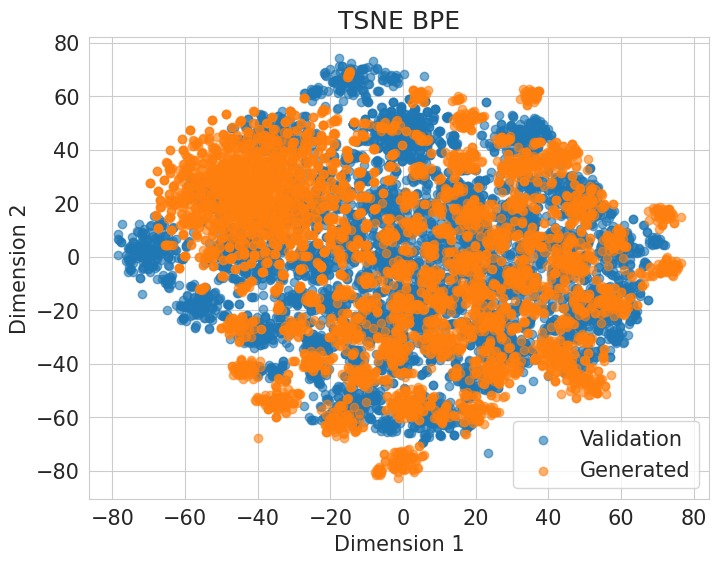

In [ ]:
visualize_lsa_vectors(val_bpe, gen_bpe, "TSNE BPE")

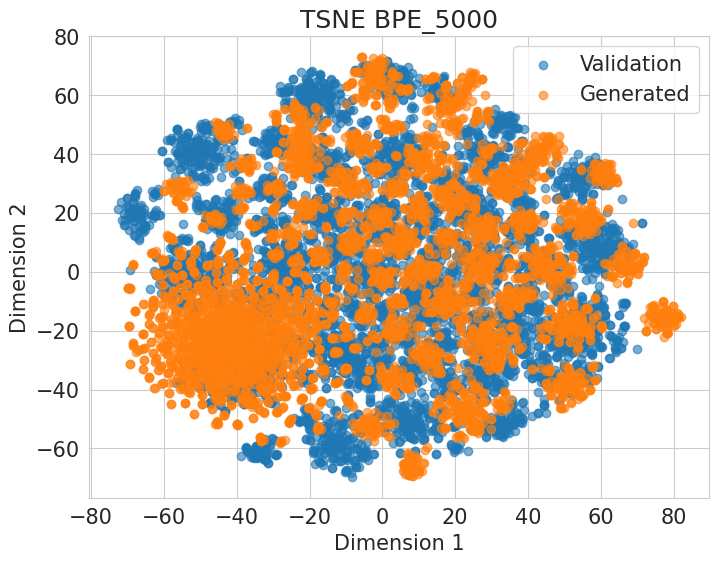

In [ ]:
visualize_lsa_vectors(val_bpe_5000, gen_bpe_5000, "TSNE BPE_5000")

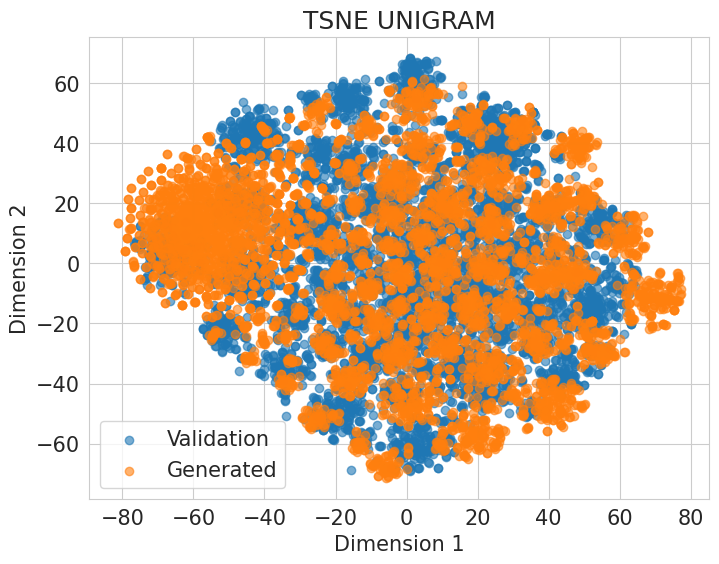

In [ ]:
visualize_lsa_vectors(val_unigram, gen_unigram, "TSNE UNIGRAM")

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")
gpt = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3small_based_on_gpt2").to(device)

In [ ]:
@torch.inference_mode()
def calculate_perplexity(model):
    encodings = tokenizer(
        '\n'.join([model.inference() for _ in tqdm(range(2077))]),
        return_tensors="pt",
        add_special_tokens=False
    )

    max_length = gpt.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = gpt(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    return torch.exp(avg_nll)

In [ ]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm.pt'))
print(f'Perplexity bpe tokenizer {calculate_perplexity(model)}')

<ipython-input-49-e4fb0b0f123f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm.pt'))
 93%|█████████▎| 56/60 [00:11<00:00,  5.09it/s]

Perplexity bpe tokenizer 361.5343322753906


In [ ]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm_bpe.pt'))
print(f'Perplexity bpe5000 {calculate_perplexity(model)}')

<ipython-input-50-73c66ff53c4e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_bpe.pt'))
 94%|█████████▎| 59/63 [00:12<00:00,  4.89i

Perplexity bpe5000 368.2515869140625


In [ ]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm_unigram.pt'))
print(f'Perplexity unigram {calculate_perplexity(model)}')

<ipython-input-51-a3e3e257320c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_unigram.pt'))
 93%|█████████▎| 57/61 [00:11<00:00,  5

Perplexity unigram 366.0170593261719


Джентельмены, вы сами все видели.

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

**Дисклеймер**

Ну анеки реально смешные получились, я просто не могу выбрать какой-то один (даже если там не все падежи согласованы). А потому я предлагаю два топа: топ законченной классики (первый из него я бы предложил для оценки), а второй это смешные фразы (они таковы были в 3 ночи, на счет утра не уверен)

Классика:
- поручик ржевский идет мимо казармы и слышит за углом характерное журчание - итак, как папа?
- василь иваныч, а что такое нюанс?- да.- а что такое?- да, но в каком-то смысле - это когда в жопу.
- поймали русского, немца и еврея. спустился к ним король и говорит- я не могу понять, что вы, змей горыныч!
- поймали русского, немца и еврея. спустился к ним король и говорит- а что это вы делаете?
- встретились русский, немец и еврей. спустился к ним король и говорит- ах, а вы не могли бы выйти замуж?

Неконченые:
- петя, кого москва промал израильщина на сиськи.
- государство. понятно, что большинство россиянину не будут уже хотеть...
муж начинает быть счастливым... как обычно, донбасса...
- изя в президента их стороны.
- василь иваныч, а что такое нюанс?- это когда ты в ней не вышел.
- василь иваныч, а что такое нюанс?- да.
- девочка - пиписьки.
- а россия начал провести стало, если потом понял, что ай - гитлер за здоровье.